In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stripROtools


# We demonstrate track pruing for the UH DLC detector - quadrant a

In [2]:
# Location of data
file_loc = ["/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_DLC/Po210/540Vmesh_2_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root", "/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_DLC/Po210/540Vmesh_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root"]

# Create pandas data frame of the cluster info
df_cluster = stripROtools.read_root(file_loc, clusters=True, hits=False)

# Define additional columns

Mult_factor = 1.366 

# number of hits
df_cluster["nhits"]=df_cluster.apply(lambda row: len(row.strips0)+len(row.strips1) ,axis=1)
df_cluster["electrons_x"] = df_cluster.adc0.apply(lambda x: 6240 * ( x  / (9.0*Mult_factor) ) ) # 9 mV/fC is VMM gain setting for x channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
df_cluster["electrons_y"] = df_cluster.adc1.apply(lambda x: 6240 * ( x / (4.5*Mult_factor) ) ) # 4.5 mV/fC is VMM gain setting for y channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
df_cluster["electrons"] = df_cluster.electrons_x + df_cluster.electrons_y

# length on x/y plane in units of strip lengths
df_cluster["L"]=np.sqrt((df_cluster.strips0.apply(np.max) - df_cluster.strips0.apply(np.min))**2 + (df_cluster.strips1.apply(np.max) - df_cluster.strips1.apply(np.min))**2)

# time range on x strips
df_cluster["TR0"] = df_cluster.times0.apply(np.max)-df_cluster.times0.apply(np.min)

# time range on y strips
df_cluster["TR1"] = df_cluster.times1.apply(np.max)-df_cluster.times1.apply(np.min)

#fiducialize clusters on s ingle vmmm combo in xHyL
df_cluster = stripROtools.fiducializeVMM(df_cluster, n_vmm_x=5, n_vmm_y=10, min_hits=5, map="UH")

# Plots after fiducializing on quadrant a 

----- Hits on y strips -----


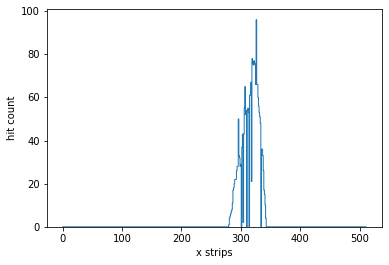

----- Hits on y strips -----


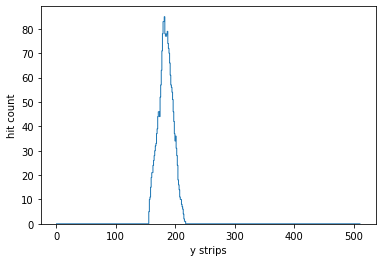

----- Event Time Range-----


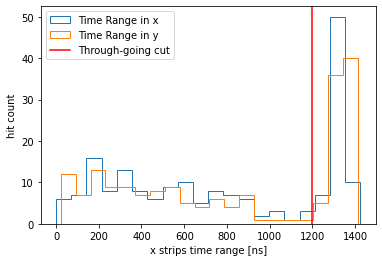

----- ADC distribution-----


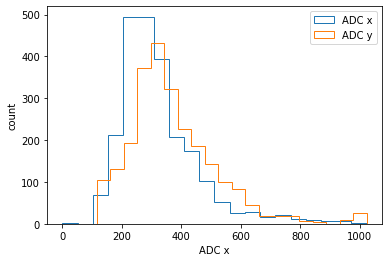

In [3]:
# plot the x hits
strip_edges = np.arange(-0.5,512.5,1.0)


print("----- Hits on y strips -----")
plt.figure()
n,bins,patches = plt.hist(np.concatenate(df_cluster.strips0),bins=strip_edges,histtype='step')
bin_centers = (bins+(bins+1))/2
#plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
plt.xlabel("x strips")
plt.ylabel("hit count")
plt.show()
# plot the y hits

print("----- Hits on y strips -----")
plt.figure()
n,bins,patches = plt.hist(np.concatenate(df_cluster.strips1),bins=strip_edges,histtype='step')
bin_centers = (bins+(bins+1))/2
#plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
plt.xlabel("y strips")
plt.ylabel("hit count")
plt.show()

# Plot the time range in x, throughgoing alphas take up the largets time range
print("----- Event Time Range-----")

plt.figure()
plt.hist(df_cluster["TR0"],bins=20,histtype='step', label="Time Range in x")
plt.hist(df_cluster["TR1"],bins=20,histtype='step', label="Time Range in y")
plt.axvline(1200, color='r',label="Through-going cut")
plt.xlabel("x strips time range [ns]")
plt.ylabel("hit count")
plt.legend()
plt.show()


#Plot ADC x distribution
print("----- ADC distribution-----")

plt.figure()
plt.hist(np.concatenate(df_cluster.adcs0), bins=20, histtype="step", label="ADC x")
plt.hist(np.concatenate(df_cluster.adcs1), bins=20, histtype="step", label="ADC y")
plt.xlabel("ADC x")
plt.ylabel("count")
plt.legend()
plt.show()


# Plots after selecting through-going tracks within 25 degrees of vertical

Number of remaining events:  31
----- hits in x -----


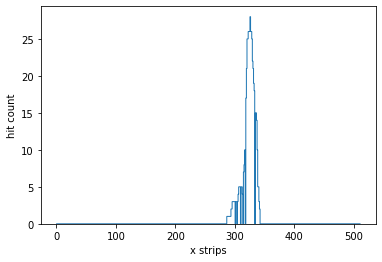

----- hits in y -----


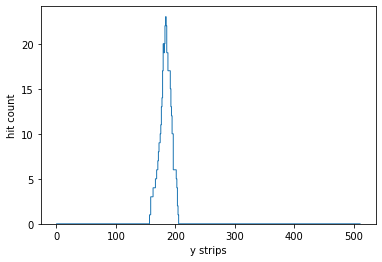

In [4]:
# Cut for throughgoing events  with over 8 hits that are within 25 degrees of vertical
df_cut = df_cluster.loc[ (df_cluster.TR0 > 1200) & (df_cluster.TR1 > 1200) & (df_cluster.nhits > 8) & (df_cluster.L <= 28) ]
df_cut=df_cut.reset_index(drop=True)

print("Number of remaining events: ", len(df_cut) )

print("----- hits in x -----")

# Plot x hits

plt.figure()
n,bins,patches = plt.hist(np.concatenate(df_cut.strips0),bins=strip_edges,histtype='step')
bin_centers = (bins+(bins+1))/2
#plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
plt.xlabel("x strips")
plt.ylabel("hit count")
plt.show()


print("----- hits in y -----")

# plot y hits
plt.figure()
n,bins,patches = plt.hist(np.concatenate(df_cut.strips1),bins=strip_edges,histtype='step')
bin_centers = (bins+(bins+1))/2
#plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
plt.xlabel("y strips")
plt.ylabel("hit count")
plt.show()

# Examples of 3D reconstructions

In [5]:
T_off = pd.read_pickle("time_offset.pk")

# 3D clustering parameters
mu = T_off.iloc[0]["Mu"]
sigma = T_off.iloc[0]["Sigma"]
n_sigma = 3

T_off

,Name,Mu,Mu_err,Sigma,Sigma_err
0,UH DLC a,-6.684141,0.031719,16.382493,0.024764
1,UH DLC b,-5.208232,0.034228,16.305925,0.026783
2,UH DLC c,6.752723,0.038583,14.113659,0.031446
3,UH DLC d,6.852294,0.058807,14.800689,0.048234
4,UH NoDLC a,5.703480,0.075588,19.574833,0.061573
5,UH NoDLC b,5.473110,0.114114,19.799337,0.092169
6,UH NoDLC c,25.241775,0.189180,18.082547,0.159142
7,UH NoDLC d,20.674842,0.698955,17.886667,0.626167
8,UoS,-11.400385,0.026963,15.290716,0.021079


[   0.   75.  100.  175.  225.  275.  350.  400.  450.  950.  575.  625.
  675.  725.  825.  900. 1000. 1075. 1125. 1150. 1200. 1325. 1350.]


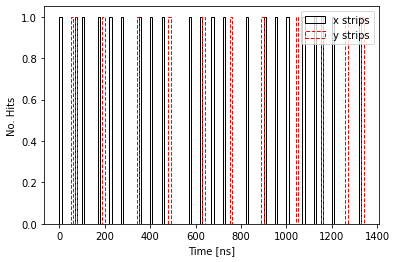

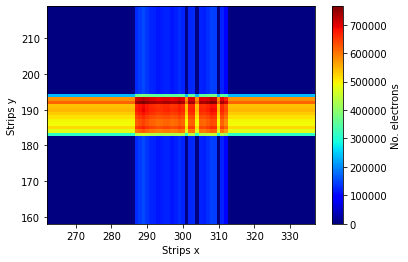

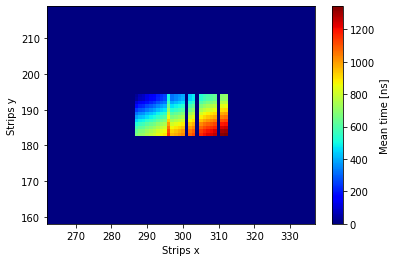

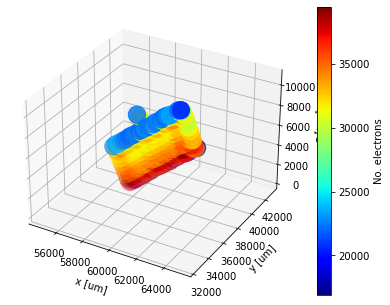

/Users/majdghrear/Lab/2DstripRO/stripROtools.py:663: RuntimeWarning: invalid value encountered in reciprocal
  abs_t_off = np.reciprocal(abs_t_off,where= abs_t_off!=0)


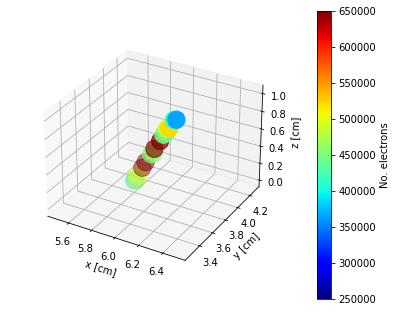

In [6]:
# Look at a single event after the cut
test_event = df_cut.iloc[5]
# Make a TrackTools object for the event
dsp = stripROtools.TrackTools(event = test_event, Mult_factor = Mult_factor, gain_x=9, gain_y=4.5, v_drift=8.0)

# Plot 1D time display
dsp.TimeHistView( t_bin =10)

# Plot 2D displays of charge and time
dsp.Strip2DView(fullview = False)
dsp.Strip2DView_times(fullview = False)

# Plot 3D displays
dsp.Reconst3D_v0()
x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma)

## See https://docs.google.com/presentation/d/1XsMB4yh1TMxGnCxlQmFeBpYkyy2Lqq5aNEsTxRmUdmk/edit#slide=id.g2914b4602e1_0_0 for a detailed discussion about track pruning.

There are 3 known issues: 

1. Too few hits on the lower strips to reconstruct

2. Seemingly unrelated hits being included in cluster 

3. Delay hits, often seen on strip

We identify and solve these issues using 3 methods.


# Method 1: Only consider tracks with >5 x hits

The x hits are counted after methods 2 and 3 have been applied

# Method 2: Using the min time / strips quantitiy

Delayed hits are clear outliers, the quantity [time difference to neighbors / distance to neighor] is above 250 for UoS and UH detectors. See distribution below.

We remove hits where min[time difference to neighbors / distance to neighor] over RHS and LHS neighbors is greater than 250 


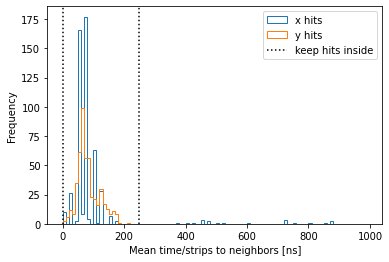

In [7]:
# Make the track pruning plot


xdiffs = np.array([])
ydiffs = np.array([])

for i in range(len(df_cut)):
    test_event = df_cut.iloc[i]

    dsp = stripROtools.TrackTools(event = test_event, gain_x=9, gain_y=4.5, v_drift=8.0)

    # For each x hit, compute the time difference to its neighboring strip on the left and right hand side
    Txdiff = np.absolute(np.diff(dsp.times_x))
    Txdiff_L = np.append(Txdiff[0],Txdiff)
    Txdiff_R = np.append(Txdiff,Txdiff[-1])
    # For each x hit, compute the distance (in strips) to the neighboring strip on the left and right hand side
    Sxdiff = np.absolute(np.diff(dsp.strips_x))
    Sxdiff_L = np.append(Sxdiff[0],Sxdiff)
    Sxdiff_R = np.append(Sxdiff,Sxdiff[-1])

    # Now find the mean of time/strips on the left vs right hand side
    xdiff = np.min([Txdiff_L/Sxdiff_L,Txdiff_R/Sxdiff_R],axis=0)

    # Append to array of xdiffs
    xdiffs = np.append(xdiffs,xdiff)

    # For each y hit, compute the time difference to its neighboring strip on the left and right hand side
    Tydiff = np.absolute(np.diff(dsp.times_y))
    Tydiff_L = np.append(Tydiff[0],Tydiff)
    Tydiff_R = np.append(Tydiff,Tydiff[-1])
    # For each x hit, compute the distance (in strips) to the neighboring strip on the left and right hand side
    Sydiff = np.absolute(np.diff(dsp.strips_y))
    Sydiff_L = np.append(Sydiff[0],Sydiff)
    Sydiff_R = np.append(Sydiff,Sydiff[-1])

    # Now find the mean of time/strips on the left vs right hand side
    ydiff = np.min( [Tydiff_L/Sydiff_L,Tydiff_R/Sydiff_R], axis = 0)

    # Append to array of xdiffs
    ydiffs = np.append(ydiffs,ydiff)

plt.hist(xdiffs, bins = np.arange(0,1000,10), histtype="step",label="x hits")
plt.hist(ydiffs, bins = np.arange(0,1000,10), histtype="step",label="y hits")
plt.axvline(250, linestyle=":",color="k",label="keep hits inside")
plt.axvline(0, linestyle=":",color="k")
plt.xlabel("Mean time/strips to neighbors [ns]")
plt.ylabel("Frequency")
plt.legend()



Because alpha tracks are straight, the time / strips to nearest neighbor is set by the angle of the track with respect to vertical and the drift speed. The fact the we select tracks that are within 25 degrees allows us to prune hits where this quantity is too small. There are also outliers where this quantity is too large - delayed or unrelated hits.

# Method 3: Use the gap to nearest neighbor quantity

In [8]:
# Make max diffs plot

all_diffs = []


for i in range(len(df_cut)):

    try:
        test_event = df_cut.iloc[i]

        dsp = stripROtools.TrackTools(event = test_event, gain_x=9, gain_y=4.5, v_drift=8.0)
        dsp.prune_track(T_L = 41.1, T_H=250)

        

        diffs = np.diff(dsp.strips_x)
        diffs_L = np.append(diffs[0],diffs)
        diffs_R = np.append(diffs,diffs[0])

        min_diffs = np.minimum(diffs_L,diffs_R)

        all_diffs = np.append(all_diffs,min_diffs)
        

    except:
        pass


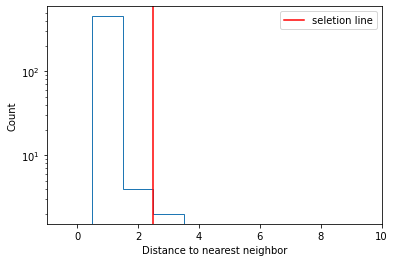

In [9]:
plt.hist(all_diffs,bins=np.arange(-0.5,10.5,1.0),histtype="step")
plt.yscale("log")
plt.xlabel("Distance to nearest neighbor")
plt.axvline(2.5,color="red",label="seletion line")
plt.ylabel("Count")
plt.legend()

We remove hits with a gap of greater than 2 strips to the nearest neighbor

# Results after appliying these methods

[1337.06811523 1287.06811523 1212.06811523 1137.06811523 1062.06811523
  987.06811523  912.06811523  837.06811523  762.06811523  687.06811523
  612.06811523  537.06811523  387.06811523  312.06811523  212.06811523
  137.06811523   62.06811523]


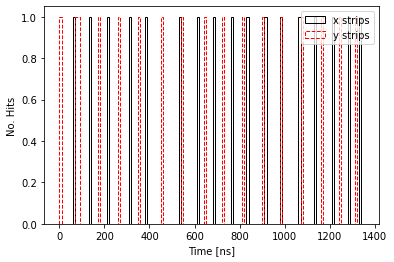

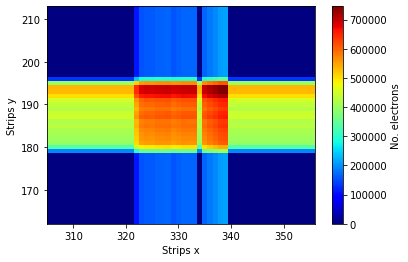

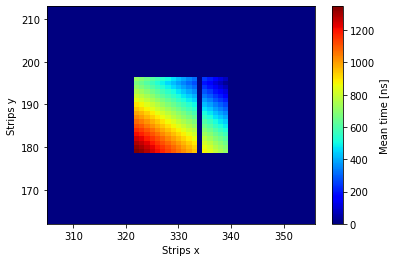

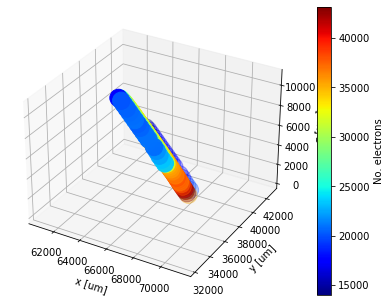

/Users/majdghrear/Lab/2DstripRO/stripROtools.py:663: RuntimeWarning: invalid value encountered in reciprocal
  abs_t_off = np.reciprocal(abs_t_off,where= abs_t_off!=0)


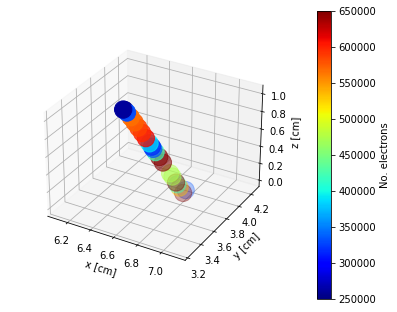

In [13]:
# Look at a single event after the cut
test_event = df_cut.iloc[2]
# Make a TrackTools object for the event
dsp = stripROtools.TrackTools(event = test_event, Mult_factor = Mult_factor, gain_x=9, gain_y=4.5, v_drift=8.0)

# Remove delayed hits (as discussed in the slides)
dsp.prune_track(T_L = 0, T_H=250)
dsp.prune_track2(gap=2)


# Plot 1D time display
dsp.TimeHistView( t_bin =10)

# Plot 2D displays of charge and time
dsp.Strip2DView(fullview = False)
dsp.Strip2DView_times(fullview = False)

# Plot 3D displays
dsp.Reconst3D_v0()
x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma,save_name = "real_alpha")